# Gradients Attribution

The gradients attribution method produces an image-specific attribution map which corresponds to the gradient of the output with respect to the input, hence the name "gradients". This is the simplest attribution method and is the easiest to implement. It can be used with any classification model, since it only depends on the inputs gradients, not any gradients from the hidden layers.

For more technical information on the gradients attribution method see: [Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/abs/1312.6034)


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp
import flax.linen as nn
import jax
from jax import random
from jax import grad
from keras.utils import data_utils
import optax

2022-11-22 18:42:58.897689: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-22 18:43:00.538210: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2022-11-22 18:43:00.538415: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2022-11-22 18:43:00.538425: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned a

### Load training data
Check if the training data exists. If not, automatically download it.

In [2]:
data_dir = os.path.abspath("./digit-recognizer")
os.makedirs(data_dir, exist_ok=True)
train_data_path = f"{data_dir}/train.zip"
train_data_url = "https://huggingface.co/datasets/ChristianOrr/mnist/resolve/main/train.zip"

if not os.path.exists(train_data_path):
    print("Downloading training data...")
    data_utils.get_file(
        train_data_path, 
        train_data_url, 
        extract=True, 
        cache_dir=data_dir
        )

data_df = pd.read_csv('./digit-recognizer/datasets/train.csv')

In [3]:
val_size = 1000
# Only shuffle training data
np.random.shuffle(data_df[val_size:].values)
m, n = data_df.shape
Y = jnp.array(data_df["label"])
data_df = data_df.drop("label", axis=1)
X = jnp.array(data_df)


X_train = X[val_size:]
X_train = X_train / 255.
Y_train = Y[val_size:]

X_val = X[:val_size]
X_val = X_val / 255.
Y_val = Y[:val_size]

### Define the classification model

In [4]:
class _forward_fn(nn.Module):

    @nn.compact
    def __call__(self, x):
        batch_size = x.shape[0]
        # Unflatten for the convolution layers
        x = x.reshape(batch_size, 28, 28, 1)
        mlp = nn.Sequential([
            nn.Conv(features=16, kernel_size=(3, 3), padding="VALID", use_bias=False), jax.nn.relu,
            nn.Conv(features=32, kernel_size=(3, 3), padding="VALID", use_bias=False), jax.nn.relu,       
        ])
        x = mlp(x)
        x = x.reshape((batch_size, -1))
        x = nn.Dense(10)(x)
        return jax.nn.softmax(x)

# Create the model object
forward_fn = _forward_fn()
# Display the model details
dummy_x = X_train[:5]
rng_key = random.PRNGKey(64)
initial_params = forward_fn.init(rng_key, dummy_x)
print(forward_fn.tabulate(rng_key, dummy_x))


                              _forward_fn Summary                               
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path         ┃ module      ┃ inputs         ┃ outputs       ┃ params         ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│              │ _forward_fn │ float32[5,784] │ float32[5,10] │                │
├──────────────┼─────────────┼────────────────┼───────────────┼────────────────┤
│ Sequential_0 │ Sequential  │ float32[5,28,… │ float32[5,24… │                │
├──────────────┼─────────────┼────────────────┼───────────────┼────────────────┤
│ Conv_0       │ Conv        │ float32[5,28,… │ float32[5,26… │ kernel:        │
│              │             │                │               │ float32[3,3,1… │
│              │             │                │               │                │
│              │             │                │               │ 144 (576 B)    │
├──────────────┼───────────

### Define the loss function and update method

In [5]:
def loss_fn(params, X, Y):
    logits = forward_fn.apply(params, X)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, Y)
    loss = loss.mean()
    return loss

def update_params(params, opt_state, X, Y, optimizer):
    grads = grad(loss_fn, argnums=0)(params, X, Y)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state

### Train the model

In [6]:
def get_predictions(logits):
    return jnp.argmax(logits, axis=1)

def get_accuracy(predictions, Y):
    return jnp.mean(predictions == Y)

def gradient_descent(X, Y, batch_size, optimizer, epochs):
    dataset_size = len(X)
    steps_per_epoch = dataset_size // batch_size

    rng = jax.random.PRNGKey(42)
    params = forward_fn.init(rng, X[0: batch_size, :])
    opt_state = optimizer.init(params)
    for epoch in range(epochs):
        dataset_step = epoch % steps_per_epoch
        dataset_index = dataset_step * batch_size
        input = X[dataset_index: dataset_index + batch_size, :]
        label = Y[dataset_index: dataset_index + batch_size, ...]

        params, opt_state = update_params(params, opt_state, input, label, optimizer)
        if epoch % 10 == 0:
            print("Epochs: ", epoch)
            logits = forward_fn.apply(params, input)
            predictions = get_predictions(logits)
            print(get_accuracy(predictions, label))
    return params

In [7]:
optimizer = optax.adam(learning_rate=0.001)

params = gradient_descent(X_train, Y_train, 1000, optimizer, 200)

Epochs:  0
0.30100003
Epochs:  10
0.83900005
Epochs:  20
0.89300007
Epochs:  30
0.93200004
Epochs:  40
0.92
Epochs:  50
0.92700005
Epochs:  60
0.94000006
Epochs:  70
0.947
Epochs:  80
0.966
Epochs:  90
0.95300007
Epochs:  100
0.96400005
Epochs:  110
0.95600003
Epochs:  120
0.961
Epochs:  130
0.96800005
Epochs:  140
0.9710001
Epochs:  150
0.9760001
Epochs:  160
0.97300005
Epochs:  170
0.96800005
Epochs:  180
0.97400004
Epochs:  190
0.97900003


### Display predictions and attribution maps

The jax "grad" function is used to extract the gradients used for the attribution map. Only the input gradients are needed, hence agrnums=1. This is different to how grad is used for training, shown above. When training only the gradients for the models parameters are needed. Its also possible to extract the input gradients while training, which could be useful for debugging.  

In [8]:
def make_predictions(X, params):
    logits = forward_fn.apply(params, X)
    predictions = get_predictions(logits)
    return predictions

def prep_image(image):
    # Normalize the gradient values to be between 0-1
    max_val= np.max(image)
    min_val = np.min(image)
    image = (image - min_val) / (max_val - min_val)
    # Convert the grads to uint8 for displaying
    image = np.uint8(image * 255)
    return image  

def display_prediction(index, params):
    current_image = X_val[None, index]
    prediction = make_predictions(X_val[None, index], params)
    label = Y_val[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    display_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(display_image, interpolation='nearest')
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Calculate the derivative WRT the input image
    attributions = grad(loss_fn, argnums=1)(params, current_image, label[None, ...])[0]

    attributions = attributions.reshape((28, 28))
    attributions = prep_image(attributions)
    plt.gray()
    plt.imshow(attributions, interpolation='nearest')
    plt.axis('off')
    plt.title("Attribution Map")
    plt.show()

Prediction:  [1]
Label:  1


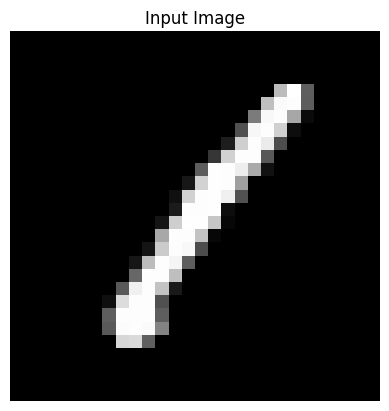

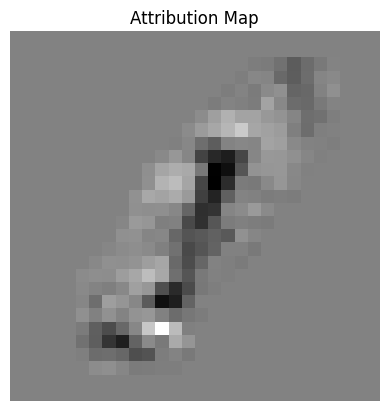

Prediction:  [4]
Label:  4


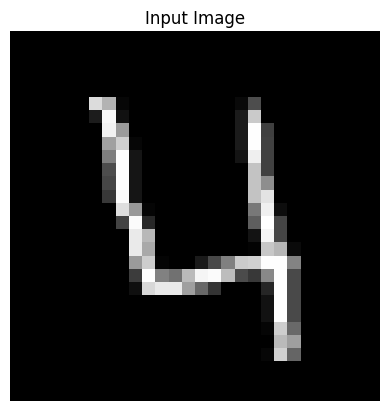

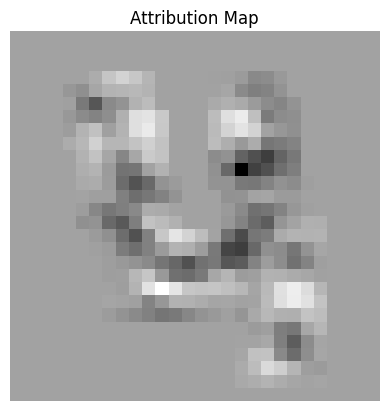

Prediction:  [0]
Label:  0


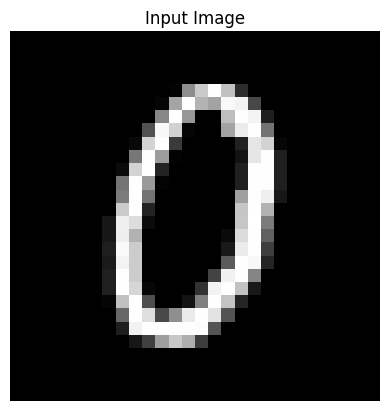

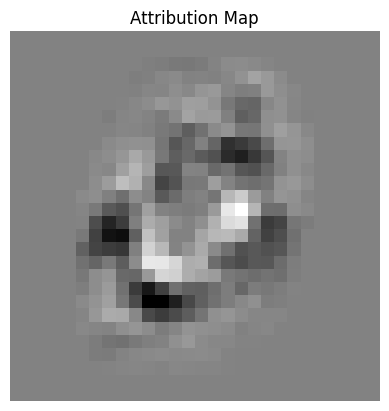

Prediction:  [5]
Label:  5


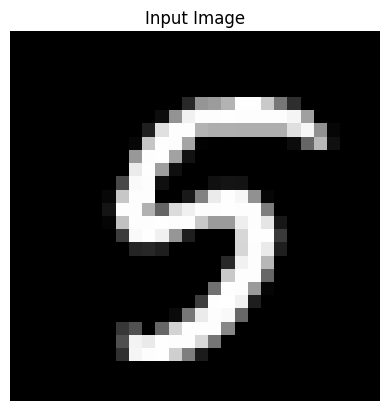

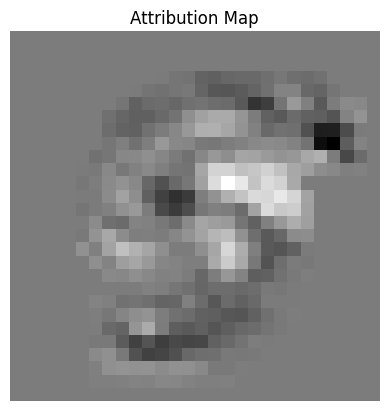

Prediction:  [8]
Label:  8


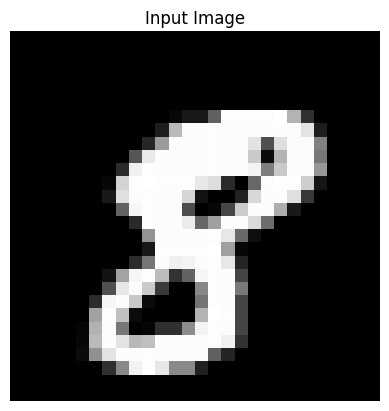

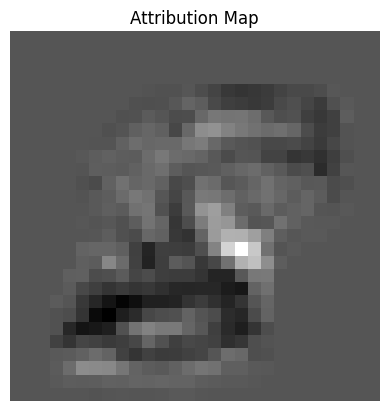

Prediction:  [7]
Label:  7


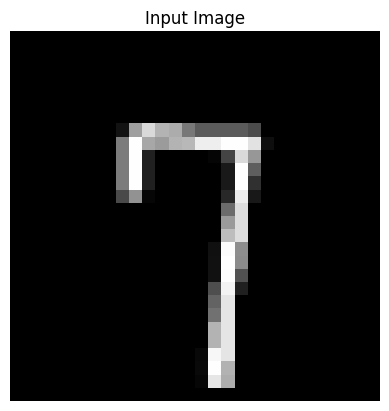

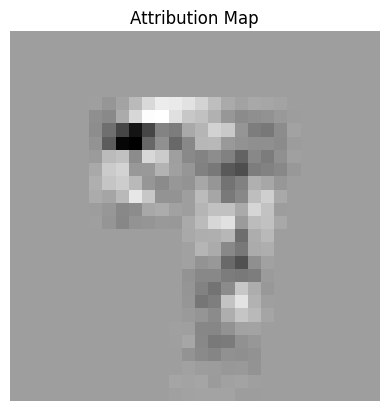

: 

In [9]:
display_prediction(0, params)
display_prediction(3, params)
display_prediction(5, params)
display_prediction(8, params)
display_prediction(10, params)
display_prediction(50, params)